# Silicon Forum — Results Analysis

Loads all `results.csv` files from the `results/` directory and analyses debate outcomes.

In [345]:
import re
import pathlib
import pandas as pd

results_root = pathlib.Path("../results")

dfs = []
for csv_path in sorted(results_root.glob("*/results.csv")):
    folder = csv_path.parent.name
    topic = re.sub(r'_\d{8}_\d{6}$', '', folder)
    df = pd.read_csv(csv_path)
    df["topic"] = topic
    df["run_folder"] = folder
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# Normalise types
df["premise_upheld"] = df["premise_upheld"].map({"TRUE": True, "FALSE": False, True: True, False: False})
df["score_for"] = pd.to_numeric(df["score_for"], errors="coerce")
df["score_against"] = pd.to_numeric(df["score_against"], errors="coerce")

print(f"Loaded {len(df)} debates from {len(dfs)} run folder(s)\n")
print("Debates per topic:")
print(df.groupby("topic").size().rename("count").to_string())
print(f"\nColumns: {list(df.columns)}")

Loaded 616 debates from 7 run folder(s)

Debates per topic:
topic
break_up_big_tech         100
free_healthcare            99
gun_control                98
immigration               100
renewable_energy_costs    119
tax_the_rich              100

Columns: ['run_num', 'agent_for', 'model_for', 'agent_against', 'model_against', 'judge', 'model_judge', 'first_speaker', 'premise', 'premise_upheld', 'winner', 'winner_side', 'score_for', 'score_against', 'transcript_filename', 'topic', 'run_folder']



## Charts

A consistent colour scheme is used throughout: **blue = FOR side wins**, **orange = AGAINST side wins**.


In [346]:

import matplotlib.pyplot as plt
import numpy as np

plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': False,
    'grid.color': 'white',
    'grid.linewidth': 1.5,
    'font.family': 'sans-serif',
    'font.sans-serif': ['Helvetica Neue', 'Helvetica', 'Arial', 'DejaVu Sans'],
    'font.size': 11,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.left': False,
    'axes.spines.bottom': False,
    'xtick.bottom': False,
    'ytick.left': False,
})

FOR_COL = '#4C72B0'   # blue    — FOR side
AGN_COL = '#C0422A'   # deep red — AGAINST side

# For charts that don't show FOR vs AGAINST (e.g. pie slices, neutral breakdowns)
NEUTRAL_COLS = ['#2A9D8F', '#7A5195', '#E9C46A', '#264653']

def fmt_topic(t):
    return t.replace('_', ' ').title()



### 1. Win rate by topic

FOR side argues the premise is true; AGAINST argues it is false. n = total debates run for that topic.


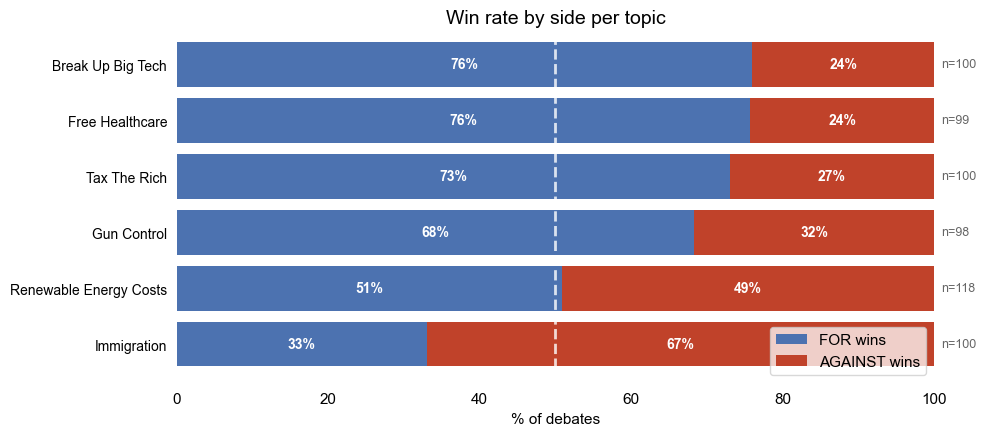

In [347]:

topic_sides = (
    df.groupby(['topic', 'winner_side'])
    .size()
    .unstack(fill_value=0)
)
for col in ['for', 'against']:
    if col not in topic_sides.columns:
        topic_sides[col] = 0

topic_totals = topic_sides.sum(axis=1)
topic_pct = topic_sides.div(topic_totals, axis=0) * 100
topic_pct['n'] = topic_totals
topic_pct.index = [fmt_topic(t) for t in topic_pct.index]
topic_pct = topic_pct.sort_values('for')

pct_for     = topic_pct['for'].values
pct_against = topic_pct['against'].values
ns          = topic_pct['n'].values.astype(int)
labels      = list(topic_pct.index)

fig, ax = plt.subplots(figsize=(10, max(4, len(labels) * 0.75)))
y = np.arange(len(labels))

ax.barh(y, pct_for, color=FOR_COL, label='FOR wins')
ax.barh(y, pct_against, left=pct_for, color=AGN_COL, label='AGAINST wins')

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=10)
ax.axvline(50, color='white', lw=2, ls='--', alpha=0.8)
ax.set_xlabel('% of debates')
ax.set_xlim(0, 100)
ax.set_title('Win rate by side per topic', fontsize=14, fontweight='normal', pad=2)
ax.legend(loc='lower right', framealpha=0.75)

for i, (f, a, n) in enumerate(zip(pct_for, pct_against, ns)):
    if f > 10:
        ax.text(f / 2, i, f'{f:.0f}%', ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    if a > 10:
        ax.text(f + a / 2, i, f'{a:.0f}%', ha='center', va='center', color='white', fontsize=10, fontweight='bold')
    ax.text(101, i, f'n={n}', va='center', fontsize=9, color='#666')

plt.tight_layout()
plt.show()



### 2. Debater win rates

Win rate per named persona. Since each persona only debates one topic, this reflects both the debater's character and the debate topic difficulty.


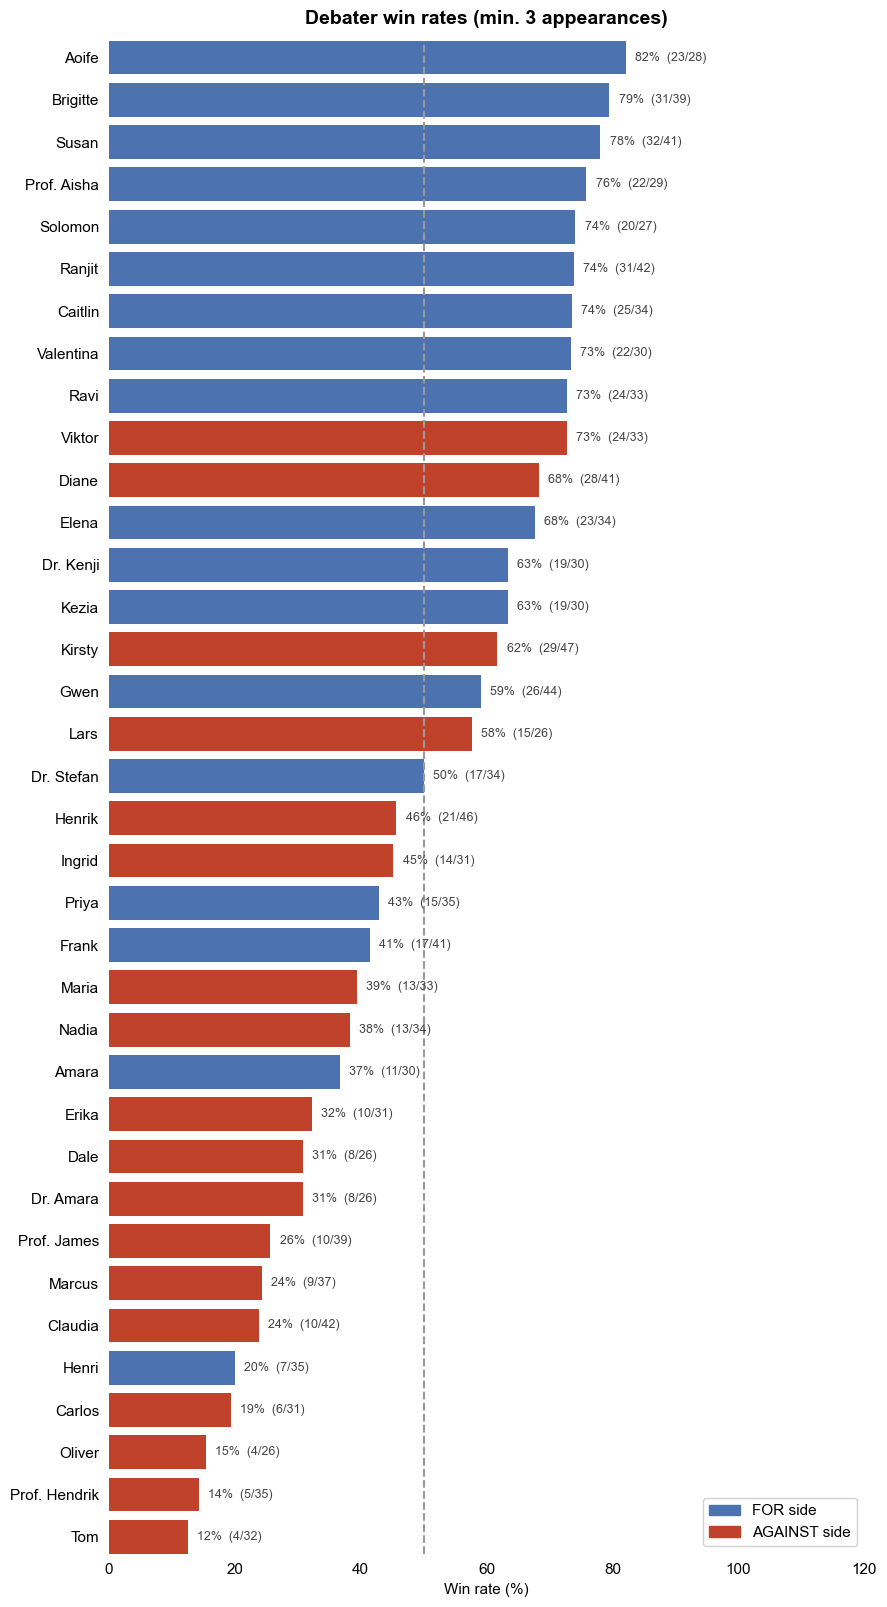

In [348]:

agent_rows = []
agent_side = {}
for _, row in df.iterrows():
    agent_rows.append({'agent': row['agent_for'],     'won': row['winner_side'] == 'for'})
    agent_rows.append({'agent': row['agent_against'], 'won': row['winner_side'] == 'against'})
    agent_side[row['agent_for']]     = 'for'
    agent_side[row['agent_against']] = 'against'

agent_df = pd.DataFrame(agent_rows)
agent_summary = (
    agent_df.groupby('agent')
    .agg(appearances=('won', 'count'), wins=('won', 'sum'))
    .reset_index()
)
agent_summary['win_pct'] = agent_summary['wins'] / agent_summary['appearances'] * 100
agent_summary = agent_summary[agent_summary['appearances'] >= 3].sort_values('win_pct')

fig, ax = plt.subplots(figsize=(9, max(4, len(agent_summary) * 0.45)))
colors = [FOR_COL if agent_side.get(a) == 'for' else AGN_COL for a in agent_summary['agent']]
bars = ax.barh(agent_summary['agent'], agent_summary['win_pct'], color=colors)
ax.margins(y=0)
ax.axvline(50, color='#999', lw=1.5, ls='--')
ax.set_xlabel('Win rate (%)')
ax.set_xlim(0, 120)
ax.set_title('Debater win rates (min. 3 appearances)', fontsize=14, fontweight='bold', pad=12)

import matplotlib.patches as mpatches
ax.legend(handles=[
    mpatches.Patch(color=FOR_COL, label='FOR side'),
    mpatches.Patch(color=AGN_COL, label='AGAINST side'),
], loc='lower right', framealpha=0.9)

for bar, (_, row) in zip(bars, agent_summary.iterrows()):
    ax.text(
        bar.get_width() + 1.5,
        bar.get_y() + bar.get_height() / 2,
        f"{row['win_pct']:.0f}%  ({int(row['wins'])}/{int(row['appearances'])})",
        va='center', fontsize=9, color='#444',
    )

plt.tight_layout()
plt.show()



#### Compact view — top 5 and bottom 3


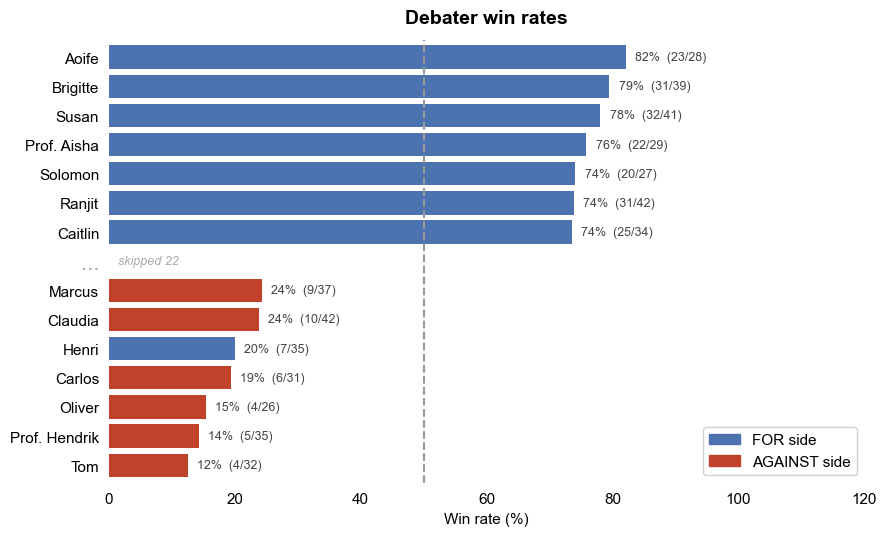

In [349]:

# Relies on agent_summary and agent_side from the cell above
n_total    = len(agent_summary)
n_bottom   = 7
n_top      = 7
n_skipped  = max(0, n_total - n_bottom - n_top)

bottom_df = agent_summary.iloc[:n_bottom]
top_df    = agent_summary.iloc[n_total - n_top:] if n_skipped > 0 else agent_summary.iloc[n_bottom:]

y_b   = list(range(n_bottom))
gap_y = n_bottom
y_t   = list(range(n_bottom + 1, n_bottom + 1 + len(top_df)))

colors_b = [FOR_COL if agent_side.get(a) == 'for' else AGN_COL for a in bottom_df['agent']]
colors_t = [FOR_COL if agent_side.get(a) == 'for' else AGN_COL for a in top_df['agent']]

fig, ax = plt.subplots(figsize=(9, 5.5))
bars_b = ax.barh(y_b, bottom_df['win_pct'].values, color=colors_b)
bars_t = ax.barh(y_t, top_df['win_pct'].values,   color=colors_t)

# Y-axis labels with ellipsis at the gap position
ax.set_yticks(y_b + [gap_y] + y_t)
ax.set_yticklabels(list(bottom_df['agent']) + ['...'] + list(top_df['agent']), fontsize=11)
ax.set_ylim(-0.6, max(y_t) + 0.6)

# Style the ⋮ tick label grey
for lbl, pos in zip(ax.get_yticklabels(), y_b + [gap_y] + y_t):
    if pos == gap_y:
        lbl.set_color('#aaa')
        lbl.set_fontsize(16)

# Annotation showing how many are omitted
if n_skipped > 0:
    ax.text(1.5, gap_y, f'skipped {n_skipped}',
            va='center', fontsize=9, color='#aaa', style='italic')

ax.axvline(50, color='#999', lw=1.5, ls='--')
ax.set_xlabel('Win rate (%)')
ax.set_xlim(0, 120)
ax.set_title('Debater win rates', fontsize=14, fontweight='bold', pad=12)

import matplotlib.patches as mpatches
ax.legend(handles=[
    mpatches.Patch(color=FOR_COL, label='FOR side'),
    mpatches.Patch(color=AGN_COL, label='AGAINST side'),
], loc='lower right', framealpha=0.9)

for bars_grp, rows_df in [(bars_b, bottom_df), (bars_t, top_df)]:
    for bar, (_, row) in zip(bars_grp, rows_df.iterrows()):
        ax.text(
            bar.get_width() + 1.5,
            bar.get_y() + bar.get_height() / 2,
            f"{row['win_pct']:.0f}%  ({int(row['wins'])}/{int(row['appearances'])})",
            va='center', fontsize=9, color='#444',
        )

plt.tight_layout()
plt.show()



### 3. Model performance as debater

Win rate per LLM split by which side it was arguing. A model may be stronger at arguing FOR or AGAINST. Requires min. 3 appearances per side for a bar to appear.


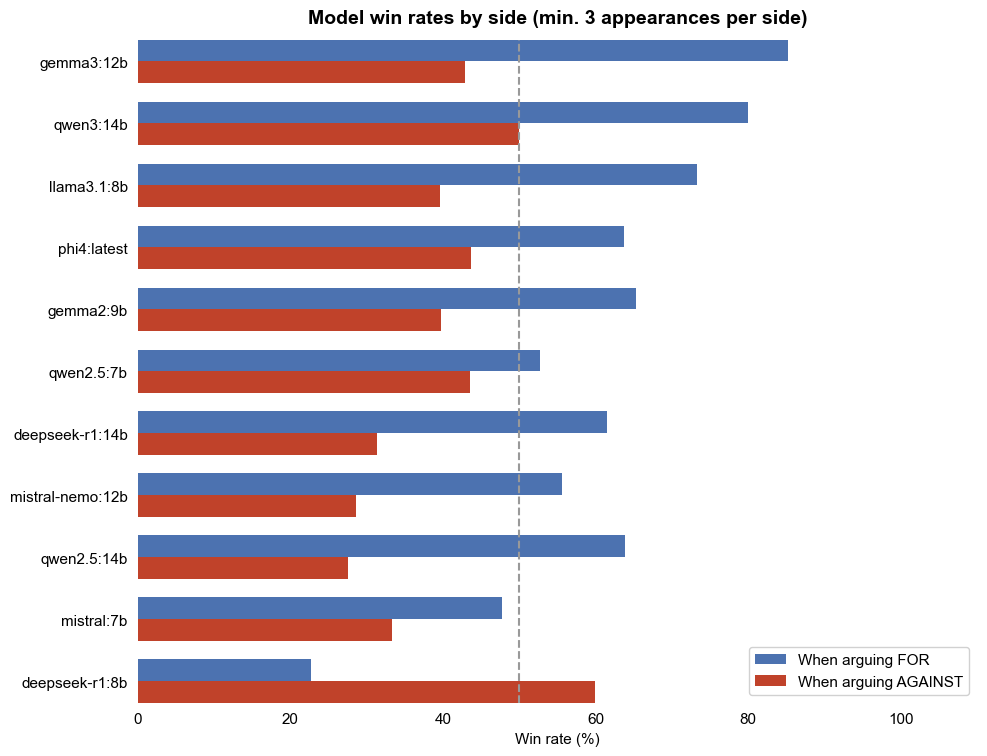

In [350]:

model_rows = []
for _, row in df.iterrows():
    model_rows.append({'model': row['model_for'],     'side': 'for',     'won': row['winner_side'] == 'for'})
    model_rows.append({'model': row['model_against'], 'side': 'against', 'won': row['winner_side'] == 'against'})

model_df = pd.DataFrame(model_rows)

# Per-side stats (min 3 appearances per side for a bar to appear)
model_by_side = (
    model_df.groupby(['model', 'side'])
    .agg(appearances=('won', 'count'), wins=('won', 'sum'))
    .reset_index()
)
model_by_side['win_pct'] = model_by_side['wins'] / model_by_side['appearances'] * 100
model_by_side = model_by_side[model_by_side['appearances'] >= 3]

# Sort models by overall win rate
model_overall = (
    model_df.groupby('model')
    .agg(total=('won', 'count'), wins=('won', 'sum'))
    .reset_index()
)
model_overall['overall_pct'] = model_overall['wins'] / model_overall['total'] * 100
model_overall = model_overall[model_overall['total'] >= 3].sort_values('overall_pct')
models = list(model_overall['model'])

for_data = model_by_side[model_by_side['side'] == 'for'].set_index('model')['win_pct']
agn_data = model_by_side[model_by_side['side'] == 'against'].set_index('model')['win_pct']

bar_h = 0.35
fig, ax = plt.subplots(figsize=(10, max(4, len(models) * 0.7)))

for_pairs = [(i + bar_h / 2, for_data[m]) for i, m in enumerate(models) if m in for_data.index]
agn_pairs = [(i - bar_h / 2, agn_data[m]) for i, m in enumerate(models) if m in agn_data.index]

if for_pairs:
    ys, ws = zip(*for_pairs)
    ax.barh(list(ys), list(ws), height=bar_h, color=FOR_COL, label='When arguing FOR')
if agn_pairs:
    ys, ws = zip(*agn_pairs)
    ax.barh(list(ys), list(ws), height=bar_h, color=AGN_COL, label='When arguing AGAINST')

ax.margins(y=0)
ax.axvline(50, color='#999', lw=1.5, ls='--')
ax.set_yticks(range(len(models)))
ax.set_yticklabels(models, fontsize=11)
ax.set_xlabel('Win rate (%)')
ax.set_xlim(0, 110)
ax.set_title('Model win rates by side (min. 3 appearances per side)', fontsize=14, fontweight='bold', pad=12)
ax.legend(loc='lower right', framealpha=0.9)

plt.tight_layout()
plt.show()



### 4. Judge leanings

Do individual judges systematically favour one side? Requires min. 3 verdicts.


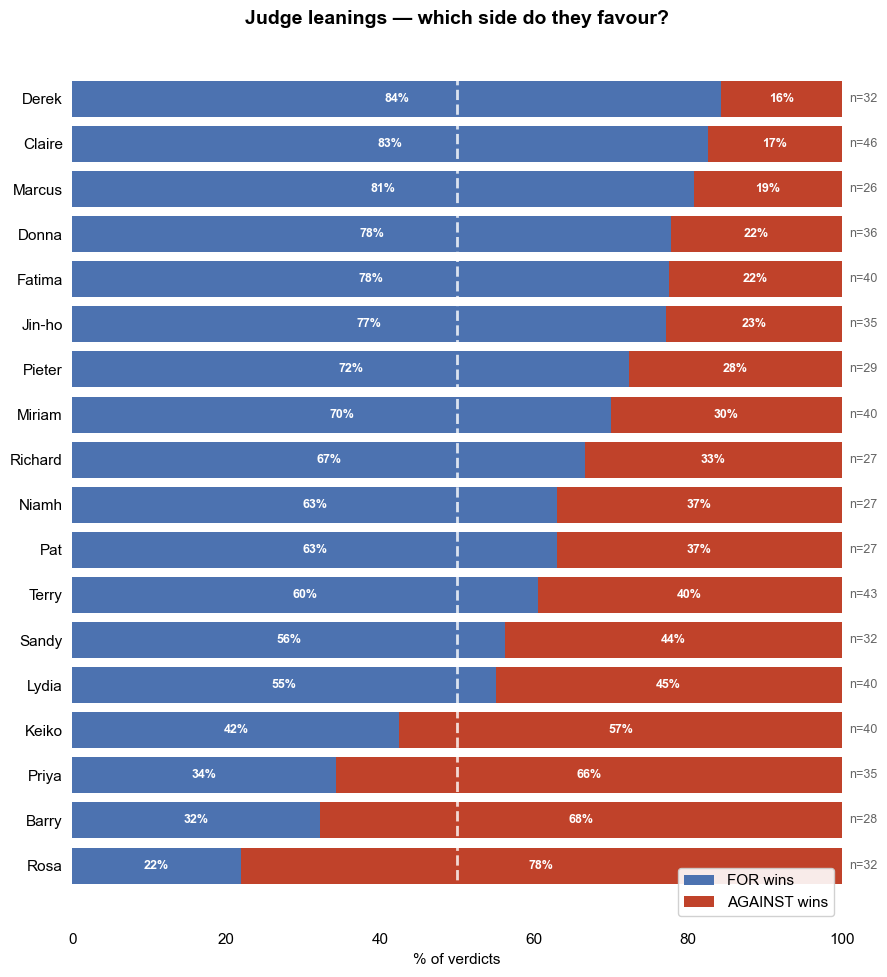

In [351]:

judge_sides = (
    df.groupby(['judge', 'winner_side'])
    .size()
    .unstack(fill_value=0)
)
for col in ['for', 'against']:
    if col not in judge_sides.columns:
        judge_sides[col] = 0

judge_totals = judge_sides.sum(axis=1)
judge_pct = judge_sides.div(judge_totals, axis=0) * 100
judge_pct['n'] = judge_totals
judge_pct = judge_pct[judge_pct['n'] >= 3].sort_values('for')

pct_for     = judge_pct['for'].values
pct_against = judge_pct['against'].values
ns          = judge_pct['n'].values.astype(int)
labels      = list(judge_pct.index)

fig, ax = plt.subplots(figsize=(9, max(4, len(labels) * 0.55)))
y = np.arange(len(labels))

ax.barh(y, pct_for, color=FOR_COL, label='FOR wins')
ax.barh(y, pct_against, left=pct_for, color=AGN_COL, label='AGAINST wins')

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=11)
ax.axvline(50, color='white', lw=2, ls='--', alpha=0.8)
ax.set_xlabel('% of verdicts')
ax.set_xlim(0, 100)
ax.set_title('Judge leanings — which side do they favour?', fontsize=14, fontweight='bold', pad=12)
ax.legend(loc='lower right', framealpha=0.9)

for i, (f, a, n) in enumerate(zip(pct_for, pct_against, ns)):
    if f > 10:
        ax.text(f / 2, i, f'{f:.0f}%', ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    if a > 10:
        ax.text(f + a / 2, i, f'{a:.0f}%', ha='center', va='center', color='white', fontsize=9, fontweight='bold')
    ax.text(101, i, f'n={n}', va='center', fontsize=9, color='#666')

plt.tight_layout()
plt.show()



### 5. First speaker advantage

Does the debater who speaks first have an edge?


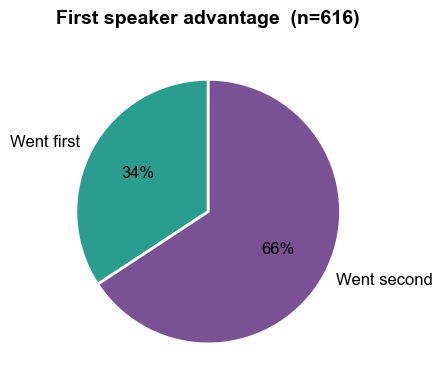

In [352]:

df['first_speaker_won'] = df['first_speaker'] == df['winner']
counts = df['first_speaker_won'].value_counts()
went_first_won  = int(counts.get(True, 0))
went_second_won = int(counts.get(False, 0))
total = went_first_won + went_second_won

fig, ax = plt.subplots(figsize=(6, 4))
ax.pie(
    [went_first_won, went_second_won],
    labels=['Went first', 'Went second'],
    colors=NEUTRAL_COLS[:2],
    autopct='%1.0f%%',
    startangle=90,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
    textprops={'fontsize': 12},
)
ax.set_title(
    f'First speaker advantage  (n={total})',
    fontsize=14, fontweight='bold', pad=16,
)
plt.tight_layout()
plt.show()



### 6. Score pairings

Each point is one debate: FOR score (x-axis) vs AGAINST score (y-axis). Colour shows who won. Points below the diagonal = FOR scored higher; above = AGAINST scored higher.


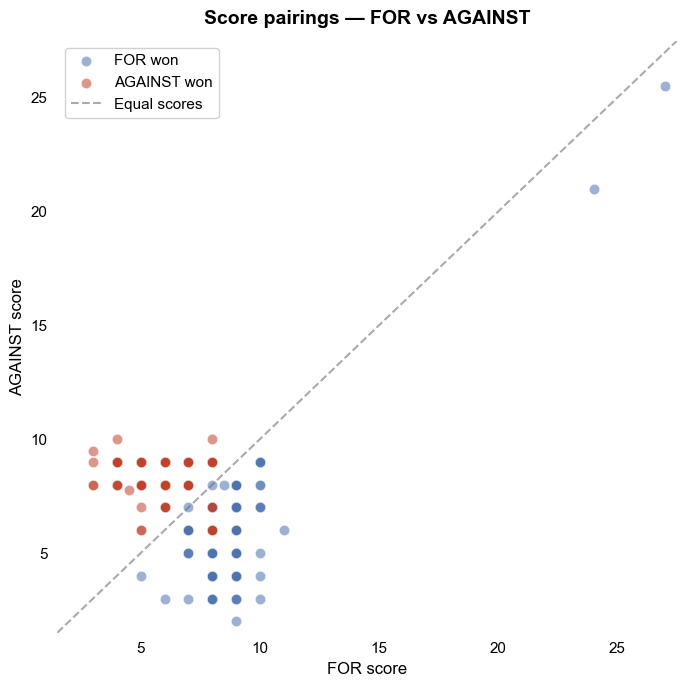

In [353]:

fig, ax = plt.subplots(figsize=(7, 7))

for side, col, label in [('for', FOR_COL, 'FOR won'), ('against', AGN_COL, 'AGAINST won')]:
    subset = df[df['winner_side'] == side]
    ax.scatter(
        subset['score_for'], subset['score_against'],
        color=col, alpha=0.55, s=55, label=label, edgecolors='white', linewidths=0.5,
    )

all_scores = pd.concat([df['score_for'], df['score_against']]).dropna()
lo = all_scores.min() - 0.5
hi = all_scores.max() + 0.5
ax.plot([lo, hi], [lo, hi], color='#aaa', lw=1.5, ls='--', label='Equal scores', zorder=0)

ax.set_xlim(lo, hi)
ax.set_ylim(lo, hi)
ax.set_xlabel('FOR score', fontsize=12)
ax.set_ylabel('AGAINST score', fontsize=12)
ax.set_title('Score pairings — FOR vs AGAINST', fontsize=14, fontweight='bold', pad=12)
ax.legend(framealpha=0.9)
plt.tight_layout()
plt.show()


### 7. Win rates by persona type

Each debate persona is tagged with one of three archetypes:

- **academic** — argues from research, data, or theoretical framework
- **practitioner** — direct real-world professional experience in the field
- **ordinary** — argues from lived experience, values, or common sense

Judges follow the same schema: **proceduralist** (rewards argument quality), **ordinary** (common sense), **stakeholder** (directly affected by the issue).


In [354]:

import yaml

debates_dir = pathlib.Path('../debates')
persona_type = {}  # (topic, name) -> type

for yaml_path in sorted(debates_dir.glob('*.yaml')):
    topic = yaml_path.stem
    with open(yaml_path) as f:
        config = yaml.safe_load(f)
    for section in ['audience', 'for', 'against']:
        for persona in config.get(section, []):
            persona_type[(topic, persona['name'])] = persona.get('type', 'unknown')

df['type_for']     = df.apply(lambda r: persona_type.get((r['topic'], r['agent_for']),     'unknown'), axis=1)
df['type_against'] = df.apply(lambda r: persona_type.get((r['topic'], r['agent_against']), 'unknown'), axis=1)
df['type_judge']   = df.apply(lambda r: persona_type.get((r['topic'], r['judge']),         'unknown'), axis=1)

unknowns = ((df[['type_for', 'type_against', 'type_judge']] == 'unknown').sum().sum())
print(f"Persona types loaded from {len(persona_type)} entries. Unresolved: {unknowns}")
print()
print(df[['type_for', 'type_against', 'type_judge']].apply(lambda c: c.value_counts()).fillna(0).astype(int))


Persona types loaded from 63 entries. Unresolved: 0

               type_for  type_against  type_judge
academic            184           157           0
ordinary            182           221         192
practitioner        250           238           0
proceduralist         0             0         223
stakeholder           0             0         201


#### 7a. Debater win rate by type

Does the archetype of a debater (academic, practitioner, ordinary person) affect their chances? Each bar shows win rate when arguing that side.


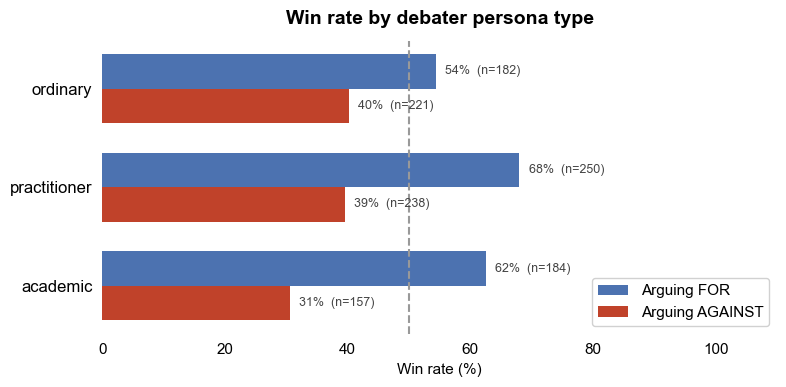

In [355]:

type_rows = []
for _, row in df.iterrows():
    type_rows.append({'ptype': row['type_for'],     'side': 'for',     'won': row['winner_side'] == 'for'})
    type_rows.append({'ptype': row['type_against'], 'side': 'against', 'won': row['winner_side'] == 'against'})

type_df = pd.DataFrame(type_rows)
type_summary = (
    type_df.groupby(['ptype', 'side'])
    .agg(n=('won', 'count'), wins=('won', 'sum'))
    .reset_index()
)
type_summary['win_pct'] = type_summary['wins'] / type_summary['n'] * 100

types = ['academic', 'practitioner', 'ordinary']
for_vals = {r['ptype']: r['win_pct'] for _, r in type_summary[type_summary['side'] == 'for'].iterrows()}
agn_vals = {r['ptype']: r['win_pct'] for _, r in type_summary[type_summary['side'] == 'against'].iterrows()}
for_ns   = {r['ptype']: int(r['n'])   for _, r in type_summary[type_summary['side'] == 'for'].iterrows()}
agn_ns   = {r['ptype']: int(r['n'])   for _, r in type_summary[type_summary['side'] == 'against'].iterrows()}

bar_h = 0.35
y = np.arange(len(types))

fig, ax = plt.subplots(figsize=(8, 4))
ax.barh(y + bar_h / 2, [for_vals.get(t, 0) for t in types], height=bar_h, color=FOR_COL, label='Arguing FOR')
ax.barh(y - bar_h / 2, [agn_vals.get(t, 0) for t in types], height=bar_h, color=AGN_COL, label='Arguing AGAINST')

ax.set_yticks(y)
ax.set_yticklabels(types, fontsize=12)
ax.axvline(50, color='#999', lw=1.5, ls='--')
ax.set_xlabel('Win rate (%)')
ax.set_xlim(0, 110)
ax.set_title('Win rate by debater persona type', fontsize=14, fontweight='bold', pad=12)
ax.legend(loc='lower right', framealpha=0.9)

for i, t in enumerate(types):
    f, a = for_vals.get(t, 0), agn_vals.get(t, 0)
    fn,  an = for_ns.get(t, 0), agn_ns.get(t, 0)
    ax.text(f + 1.5, i + bar_h / 2, f'{f:.0f}%  (n={fn})', va='center', fontsize=9, color='#444')
    ax.text(a + 1.5, i - bar_h / 2, f'{a:.0f}%  (n={an})', va='center', fontsize=9, color='#444')

plt.tight_layout()
plt.show()


#### 7b. Judge leaning by type

Do different judge archetypes systematically favour one side? Proceduralists reward argument quality; ordinary-person judges reward relatable reasoning; stakeholders weigh real-world impact.


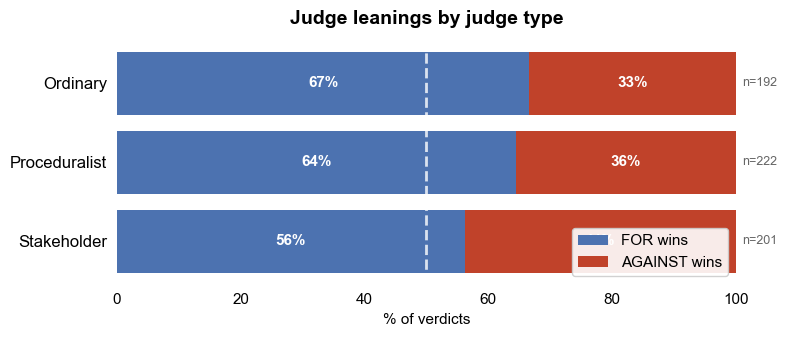

In [356]:

judge_type_sides = (
    df.groupby(['type_judge', 'winner_side'])
    .size()
    .unstack(fill_value=0)
)
for col in ['for', 'against']:
    if col not in judge_type_sides.columns:
        judge_type_sides[col] = 0

judge_type_totals = judge_type_sides.sum(axis=1)
judge_type_pct = judge_type_sides.div(judge_type_totals, axis=0) * 100
judge_type_pct['n'] = judge_type_totals
judge_type_pct = judge_type_pct.sort_values('for')
judge_type_pct.index = [t.title() for t in judge_type_pct.index]

pct_for     = judge_type_pct['for'].values
pct_against = judge_type_pct['against'].values
ns          = judge_type_pct['n'].values.astype(int)
labels      = list(judge_type_pct.index)

fig, ax = plt.subplots(figsize=(8, 3.5))
y = np.arange(len(labels))

ax.barh(y, pct_for, color=FOR_COL, label='FOR wins')
ax.barh(y, pct_against, left=pct_for, color=AGN_COL, label='AGAINST wins')

ax.set_yticks(y)
ax.set_yticklabels(labels, fontsize=12)
ax.axvline(50, color='white', lw=2, ls='--', alpha=0.8)
ax.set_xlabel('% of verdicts')
ax.set_xlim(0, 100)
ax.set_title('Judge leanings by judge type', fontsize=14, fontweight='bold', pad=12)
ax.legend(loc='lower right', framealpha=0.9)

for i, (f, a, n) in enumerate(zip(pct_for, pct_against, ns)):
    if f > 10:
        ax.text(f / 2, i, f'{f:.0f}%', ha='center', va='center', color='white', fontsize=11, fontweight='bold')
    if a > 10:
        ax.text(f + a / 2, i, f'{a:.0f}%', ha='center', va='center', color='white', fontsize=11, fontweight='bold')
    ax.text(101, i, f'n={n}', va='center', fontsize=9, color='#666')

plt.tight_layout()
plt.show()


#### 7c. Debater type vs judge type

A 3×3 heatmap for each side. Rows = debater archetype, columns = judge archetype. Cell shows win rate and n for that combination. Green = wins often, red = wins rarely. The two panels use the same colour scale so comparisons across sides are direct.


In [ ]:

# Cross-tab: debater type × judge type win rates, split by side
cross_rows = []
for _, row in df.iterrows():
    cross_rows.append({'debater_type': row['type_for'],     'judge_type': row['type_judge'], 'side': 'for',     'won': row['winner_side'] == 'for'})
    cross_rows.append({'debater_type': row['type_against'], 'judge_type': row['type_judge'], 'side': 'against', 'won': row['winner_side'] == 'against'})

cross_df = pd.DataFrame(cross_rows)

debater_types = ['academic', 'practitioner', 'ordinary']
judge_types   = ['proceduralist', 'ordinary', 'stakeholder']

def make_matrix(side):
    g = (
        cross_df[cross_df['side'] == side]
        .groupby(['debater_type', 'judge_type'])
        .agg(n=('won', 'count'), wins=('won', 'sum'))
        .reset_index()
    )
    g['win_pct'] = g['wins'] / g['n'] * 100
    pct = g.pivot(index='judge_type', columns='debater_type', values='win_pct').reindex(index=judge_types, columns=debater_types)
    ns  = g.pivot(index='judge_type', columns='debater_type', values='n').reindex(index=judge_types, columns=debater_types)
    return pct.values, ns.values

pct_for, ns_for = make_matrix('for')
pct_agn, ns_agn = make_matrix('against')

fig, axes = plt.subplots(2, 1, figsize=(7, 7))

for ax, pct, ns, title, base_col in [
    (axes[0], pct_for, ns_for, 'FOR debaters',     FOR_COL),
    (axes[1], pct_agn, ns_agn, 'AGAINST debaters', AGN_COL),
]:
    ax.imshow(pct, cmap='Greens', vmin=30, vmax=70, aspect='auto')

    ax.set_xticks(range(len(debater_types)))
    ax.set_xticklabels([t.title() for t in debater_types], fontsize=11)
    ax.set_yticks(range(len(judge_types)))
    ax.set_yticklabels([t.title() for t in judge_types], fontsize=11)
    ax.set_xlabel('Debater', fontsize=11)
    ax.set_ylabel('Judge', fontsize=11)
    ax.set_title(title, fontsize=13, fontweight='bold', color=base_col, pad=10)

    for i in range(len(judge_types)):
        for j in range(len(debater_types)):
            v, n = pct[i, j], ns[i, j]
            if not np.isnan(v):
                text_col = 'white' if v > 55 else 'black'
                ax.text(j, i, f'{v:.0f}%\n(n={int(n)})',
                        ha='center', va='center', fontsize=10,
                        color=text_col, fontweight='bold')

fig.suptitle('Win rate: debater type vs judge type', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()


#### 7d. Debater type vs judge type — combined

Same cross-tab but FOR and AGAINST pooled. Since each debate contributes one debater per side, the baseline is 50%. Cells above 50% mean that archetype wins more than half the time against that judge type regardless of which side they are arguing.


In [ ]:

# Combined: pool FOR and AGAINST — overall win rate by debater type × judge type
all_rows = []
for _, row in df.iterrows():
    all_rows.append({'debater_type': row['type_for'],     'judge_type': row['type_judge'], 'won': row['winner_side'] == 'for'})
    all_rows.append({'debater_type': row['type_against'], 'judge_type': row['type_judge'], 'won': row['winner_side'] == 'against'})

all_df = pd.DataFrame(all_rows)
g = (
    all_df.groupby(['debater_type', 'judge_type'])
    .agg(n=('won', 'count'), wins=('won', 'sum'))
    .reset_index()
)
g['win_pct'] = g['wins'] / g['n'] * 100
pct = g.pivot(index='judge_type', columns='debater_type', values='win_pct').reindex(index=judge_types, columns=debater_types)
ns  = g.pivot(index='judge_type', columns='debater_type', values='n').reindex(index=judge_types, columns=debater_types)

fig, ax = plt.subplots(figsize=(7, 3.5))
ax.imshow(pct.values, cmap='Greens', vmin=30, vmax=70, aspect='auto')

ax.set_xticks(range(len(debater_types)))
ax.set_xticklabels([t.title() for t in debater_types], fontsize=11)
ax.set_yticks(range(len(judge_types)))
ax.set_yticklabels([t.title() for t in judge_types], fontsize=11)
ax.set_xlabel('Debater', fontsize=11)
ax.set_ylabel('Judge', fontsize=11)
ax.set_title('Win rate by debater type vs judge type — both sides combined', fontsize=13, fontweight='bold', pad=10)

for i in range(len(judge_types)):
    for j in range(len(debater_types)):
        v, n = pct.values[i, j], ns.values[i, j]
        if not np.isnan(v):
            text_col = 'white' if v > 55 else 'black'
            ax.text(j, i, f'{v:.0f}%\n(n={int(n)})',
                    ha='center', va='center', fontsize=10,
                    color=text_col, fontweight='bold')

plt.tight_layout()
plt.show()
